In [1]:
import os
import yaml

import math

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.lines import Line2D
from matplotlib.colors import TwoSlopeNorm
from matplotlib.widgets import LassoSelector

from tifffile import imread
from PIL import Image, ImageDraw

import napari

from umap import UMAP

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
        }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
        ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [3]:
class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

In [4]:
# read and process input data

# out dir
out_dir = '../output/Fig1j-ExtFig1d,e'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# read aggregate csv data
agg = pd.read_parquet('../input/Dataset7(CODEX7)/CODEX7_clean_cylinter_aggregateData.parquet')

# read markers.csv
markers = pd.read_csv('../input/Dataset7(CODEX7)/markers.csv')

# log-transform columns to be used in clustering
clustering_cols = [
    i for i in list(markers['marker_name']) if i in agg.columns
    if 'Hoechst' not in i
]
data = agg[['CellID', 'X_centroid', 'Y_centroid'] + clustering_cols].copy()

log_data = np.log10(data[clustering_cols] + 0.001)
data.update(log_data)

# define image crop window
row_min = 5757
row_max = 8104
col_min = 5032
col_max = 8260

# select single cells within cropped image
data_crop = data[
    (data['X_centroid'].between(col_min, col_max)) &
    (data['Y_centroid'].between(row_min, row_max))].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid'] - col_min
data_crop['Y_centroid'] = data_crop['Y_centroid'] - row_min

# read segmentation outlines and crop
seg = imread('../input/Dataset7(CODEX7)/seg/HBM524.VWGB.378.ome.tif', key=0)
seg_crop = seg[row_min:row_max, col_min:col_max]

# read DNA1 image, crop, and convert to RGB
dna = imread('../input/Dataset7(CODEX7)/tif/HBM524.VWGB.378.ome.tif', key=0)
dna_float = img_as_float(dna)
dna_float -= dna_float.min()
dna_float /= dna_float.max()
dna_crop = dna_float[row_min:row_max, col_min:col_max]
dna_crop_rgb = gray2rgb(dna_crop)

# read CD3 channel of image, crop, and convert to RGB with colormap
cd3_raw = imread('../input/Dataset7(CODEX7)/tif/HBM524.VWGB.378.ome.tif', key=30)
cd3 = np.clip(cd3_raw, cd3_raw.min(), 9169)  # clipping to preferred intensity
cd3_float = img_as_float(cd3)
cd3_float -= cd3_float.min()
cd3_float /= cd3_float.max()
cd3_crop = cd3_float[row_min:row_max, col_min:col_max].copy()
cd3_crop_rgb = (
    (cd3_crop - np.min(cd3_crop)) / (np.max(cd3_crop) - np.min(cd3_crop))
)  # normalize 0-1

cd3_crop_rgb = plt.cm.magma(cd3_crop_rgb)  # converts to RGBA
cd3_crop_rgb = cd3_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb /= 1.0  # modify DNA intensity if needed and combine CD3 image with DNA image
dna_crop_rgb += cd3_crop_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


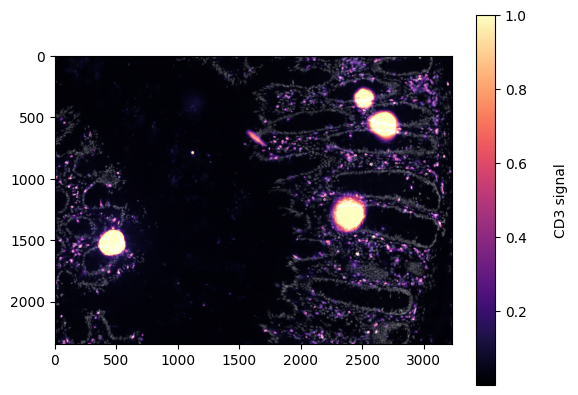

In [5]:
# plot image overlay

plt.imshow(dna_crop_rgb, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('CD3 signal', labelpad=20, rotation=90)
plt.savefig(os.path.join(out_dir, 'image.png'), dpi=800)
plt.show()
plt.close('all')

In [6]:
# open CODEX image in Napari to select ROIs (if not already done) 
viewer = napari.Viewer()

viewer.add_image(dna_crop, opacity=1.0, rgb=False, name='DNA1')

viewer.add_image(
    seg_crop, rgb=False, blending='additive', opacity=1.0, 
    colormap='green', visible=False, name='segmentation'
)

viewer.add_image(
    cd3_crop, rgb=False, blending='additive', colormap='magma',
    visible=True, name='CD3'
)

# read saved polygon vertices (if ROIs have been drawn already) 
if os.path.exists(os.path.join(out_dir, 'rois.yml')):

    polygon_dict = yaml.safe_load(open(os.path.join(out_dir, 'rois.yml')))
    
    shapes = [polygon_dict[i][0] for i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for i in range(0, len(polygon_dict.keys()))]

    selection_layer = viewer.add_shapes(
        data=polygons,
        shape_type=shapes,
        ndim=2,
        face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
        edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
        edge_width=20.0,
        name='ROI(s)') 
else:
    selection_layer = viewer.add_shapes(
        shape_type='polygon', ndim=2, face_color=[1.0, 1.0, 1.0, 0.2],
        edge_color=[0.0, 0.66, 1.0, 1.0], edge_width=10.0, name='ROI(s)'
    )
    
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()
 
# store ROIs
for e, (shape_type, roi) in enumerate(
        zip(selection_layer.shape_type, selection_layer.data)):
    polygon_dict[e] = [shape_type, roi.tolist()]

f = open(os.path.join(out_dir, 'rois.yml'), 'w')
yaml.dump(polygon_dict, f)

In [7]:
# create a dictionary containing cellIDs (values) for each ROI (keys)

roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, value in polygon_dict.items():

    selection_verts = np.round(value[1]).astype(int)

    # create pillow image to convert to boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    vertices = list(tuple(
        zip(selection_verts[:, 1],
            selection_verts[:, 0])
    ))

    # update pillow image with polygon
    ImageDraw.Draw(img).polygon(
        vertices, outline=1, fill=1
    )

    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]
 
    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

Performing UMAP embedding...


/Users/greg/venvs/cylinter/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


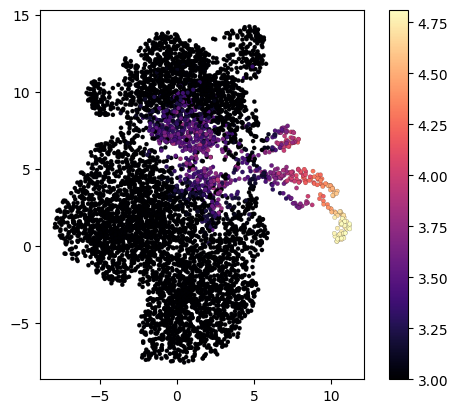

In [8]:
# calculate UMAP coordinates of cropped data and plot

print('Performing UMAP embedding...')
embedding = (
    UMAP(random_state=4, n_neighbors=57, min_dist=1.0, repulsion_strength=1.0)
    .fit_transform(data_crop[clustering_cols])
)
data_crop['emb1'] = embedding[:, 0]
data_crop['emb2'] = embedding[:, 1]

# plot
fig, ax = plt.subplots()
lw = 0.1

sc = ax.scatter(
    data_crop['emb1'], data_crop['emb2'], c=data_crop['CD3'], cmap='magma',
    s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3, vmax=data_crop['CD3'].max())

plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'embedding_CD3.png'), dpi=1000)
plt.show()
plt.close('all')

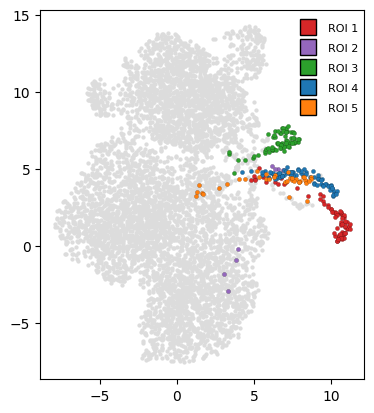

In [9]:
# plot UMAP embedding colored by ROI

# combine cellIDs from each ROI
combo_ids = set()

legend_elements = []
roi_data = {}

for k, v, in cell_ids_dict.items():

    if k == 0:
        name = 'ROI 1'
        roi_data[name] = ('tab:red', data_crop[data_crop['CellID'].isin(v)])
    elif k == 1:
        name = 'ROI 2'
        roi_data[name] = ('tab:purple', data_crop[data_crop['CellID'].isin(v)])
    elif k == 2:
        name = 'ROI 3'
        roi_data[name] = ('tab:green', data_crop[data_crop['CellID'].isin(v)])
    elif k == 3:
        name = 'ROI 4'
        roi_data[name] = ('tab:blue', data_crop[data_crop['CellID'].isin(v)])
    elif k == 4:
        name = 'ROI 5'
        roi_data[name] = ('tab:orange', data_crop[data_crop['CellID'].isin(v)])

    combo_ids.update(cell_ids_dict[k])
    
    legend_elements.append(
        Line2D([0], [0], marker='s',
               color='none',
               label=name,
               markerfacecolor=roi_data[name][0],
               markeredgecolor='k',
               lw=0.01, markersize=12)
    )

data_sans_rois = data_crop[~data_crop['CellID'].isin(combo_ids)].copy()

# plot
fig, ax = plt.subplots() 
ax.scatter(
    data_sans_rois['emb1'], data_sans_rois['emb2'], c='gainsboro', s=9.5,
    ec='k', lw=0.0, alpha=1.0
)
for k, v in roi_data.items():
    ax.scatter(v[1]['emb1'], v[1]['emb2'], c=v[0], s=9.5, ec='k', lw=lw, alpha=1.0)

ax.set_aspect('equal')

ax.legend(
    handles=legend_elements, prop={'size': 8}, loc='upper left',
    bbox_to_anchor=[0.76, 0.99], labelspacing=0.9, frameon=False
)

plt.savefig(os.path.join(out_dir, 'embedding_gate.png'), dpi=1000)
plt.show()
plt.close('all')

Performing UMAP embedding...


/Users/greg/venvs/cylinter/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


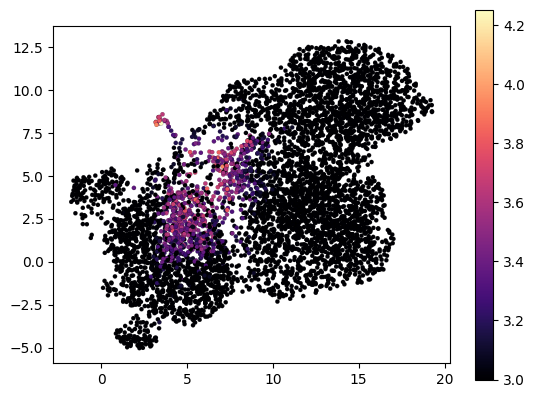

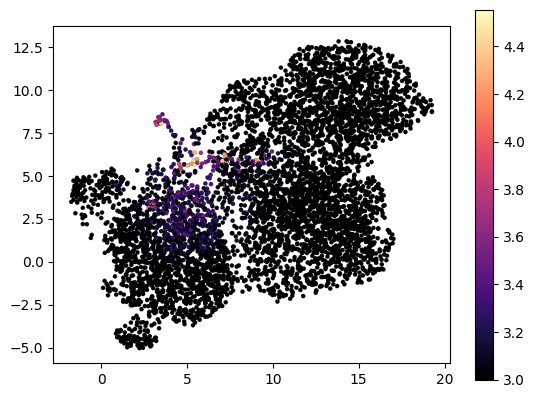

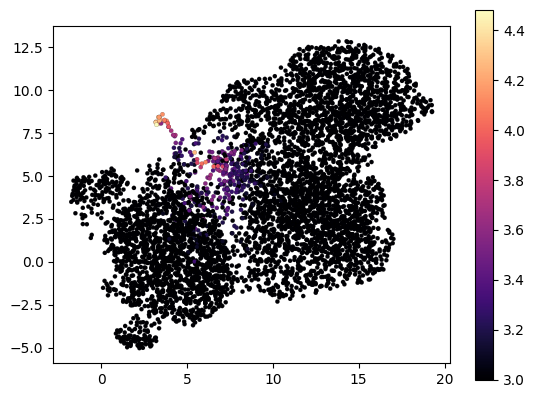

In [10]:
# calculate UMAP coordinates of cropped data and plot, only including cells outside ROI selection

print('Performing UMAP embedding...')
embedding = (
    UMAP(random_state=1, n_neighbors=56, min_dist=1.0, repulsion_strength=1.0)
    .fit_transform(data_sans_rois[clustering_cols])
)
data_sans_rois['emb1'] = embedding[:, 0]
data_sans_rois['emb2'] = embedding[:, 1]

# plot colored by CD3
fig, ax = plt.subplots()
sc = ax.scatter(
    data_sans_rois['emb1'], data_sans_rois['emb2'], c=data_sans_rois['CD3'], cmap='magma',
    s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3, vmax=data_sans_rois['CD3'].max())

plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'embedding_CD3_noArtifacts.png'), dpi=1000)
plt.show()

# plot colored by CD4
fig, ax = plt.subplots()
sc = ax.scatter(
    data_sans_rois['emb1'], data_sans_rois['emb2'], c=data_sans_rois['CD4'], cmap='magma',
    s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3, vmax=data_sans_rois['CD4'].max())

plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'embedding_CD4_noArtifacts.png'), dpi=1000)
plt.show()

# plot colored by CD8
fig, ax = plt.subplots()
sc = ax.scatter(
    data_sans_rois['emb1'], data_sans_rois['emb2'], c=data_sans_rois['CD8'], cmap='magma',
    s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3, vmax=data_sans_rois['CD8'].max())

plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(out_dir, 'embedding_CD8_noArtifacts.png'), dpi=1000)
plt.show()

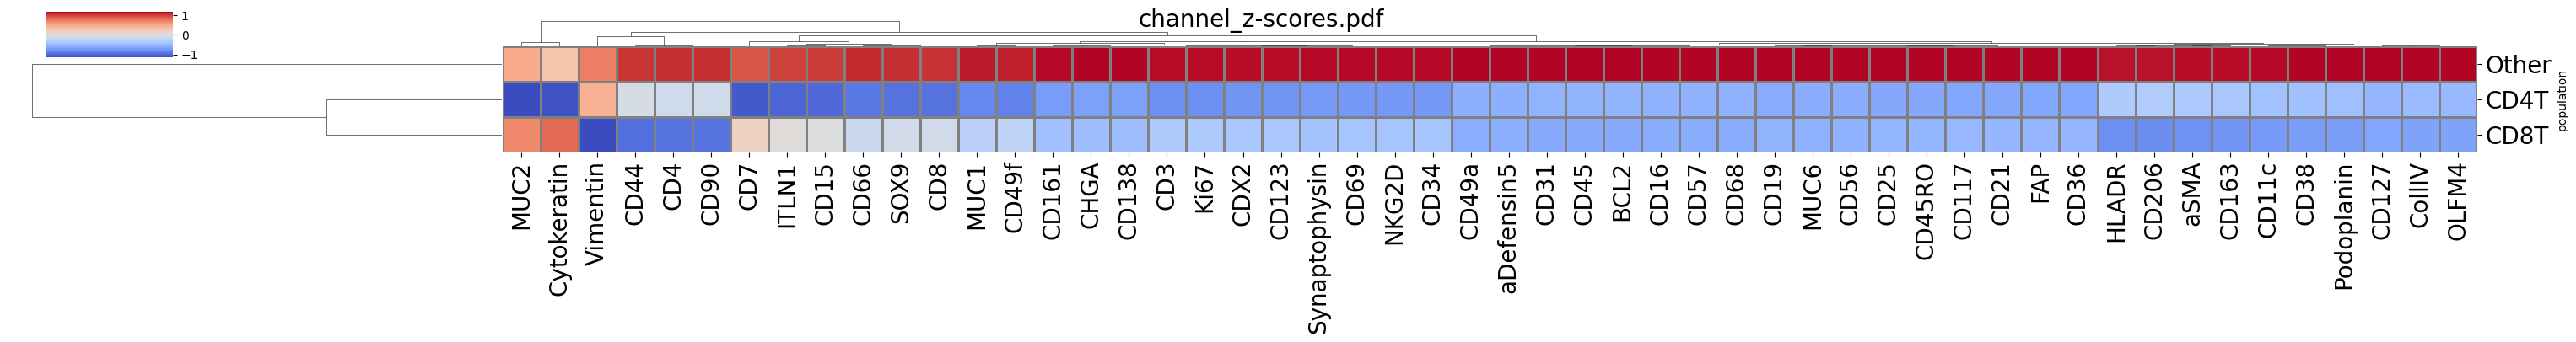

In [11]:
# lasso cells in UMAP embedding and generate z-score-normalized clustermap

data_sans_rois = data_sans_rois.reset_index(drop=True)

if os.path.exists(os.path.join(out_dir, 'lassoed_cells.yml')):
    my_selections = yaml.safe_load(open(os.path.join(out_dir, 'lassoed_cells.yml')))

else:
    my_selections = {}
    my_selections['CD4T'] = None
    my_selections['CD8T'] = None
    my_selections['Other'] = None

    pops = list(my_selections.keys())

    for pop in pops:
        subplot_kw = dict(
            xlim=(data_sans_rois['emb1'].min(), data_sans_rois['emb1'].max()),
            ylim=(data_sans_rois['emb2'].min(), data_sans_rois['emb2'].max()),
            autoscale_on=False
        )

        fig, lasso_ax = plt.subplots(subplot_kw=subplot_kw, figsize=(9, 8))

        pts = lasso_ax.scatter(
            data_sans_rois['emb1'], data_sans_rois['emb2'], c=data_sans_rois['CD3'], cmap='magma',
            s=30.0, lw=0.25, vmin=3, vmax=data_sans_rois['CD3'].max(), zorder=4
        )

        lasso_ax.update_datalim(np.column_stack([data_sans_rois['emb1'], data_sans_rois['emb2']]))
        lasso_ax.autoscale()

        selector = SelectFromCollection(lasso_ax, pts)

        def accept(event):
            if event.key == "enter":
                print("Selected points:")
                print(selector.xys[selector.ind])
                selector.disconnect()
                lasso_ax.set_title("")
                fig.canvas.draw()

        fig.canvas.mpl_connect("key_press_event", accept)
        lasso_ax.set_title("Press enter to accept selected points.")
        lasso_ax.set_aspect('equal')
        plt.show(block=True)

        selected_vectors = data_sans_rois.loc[selector.ind]
        selected_vectors['population'] = pop
        
        my_selections[pop] = selected_vectors.to_dict(orient='records')

    # save dataframes for lassoed cells
    f = open(os.path.join(out_dir, 'lassoed_cells.yml'), 'w')
    yaml.dump(my_selections, f)

combo = pd.concat(
    [pd.DataFrame.from_dict(my_selections['CD4T']),
     pd.DataFrame.from_dict(my_selections['CD8T']),
     pd.DataFrame.from_dict(my_selections['Other'])], axis=0
)

# compute channel means independently on gated cell populations
clustermap_input = combo[clustering_cols + ['population']].groupby('population').mean()

# compute per channel z-scores across gated populations 
clustermap_input = (
    (clustermap_input - clustermap_input.mean()) / clustermap_input.std()
)

# zero-center colorbar
norm = TwoSlopeNorm(
    vcenter=0, vmin=clustermap_input.min().min(),
    vmax=clustermap_input.max().max()
)

g = sns.clustermap(
    clustermap_input, cmap='coolwarm', standard_scale=None, square=False,
    xticklabels=1, yticklabels=1, linewidth=1.0, linecolor='grey', cbar=True,
    norm=norm, figsize=(30,3)
)

g.fig.suptitle('channel_z-scores.pdf', y=0.995, fontsize=20)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, size=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, size=20)
plt.savefig(
    os.path.join(out_dir, 'channel_z-scores.pdf'), bbox_inches='tight'
)
plt.show()
plt.close('all')

In [12]:
# visualize gated populations in Napari

viewer = napari.Viewer()

viewer.add_image(dna_crop, opacity=1.0, rgb=False, name='DNA1')

viewer.add_image(
    seg_crop, rgb=False, blending='additive', opacity=1.0,
    visible=False, name='segmentation'
)

for ch in reversed(clustering_cols):
    
    if ch in ['CD4', 'CD8', 'CD3']:
        channel_number = markers.index[markers['marker_name'] == ch].item()

        img = imread(
            '../input/Dataset7(CODEX7)/tif/HBM524.VWGB.378.ome.tif',
            key=channel_number
        )
        
        if ch == 'CD4':
            c = 'bop orange'
            min, max = (462, 4615)
        elif ch == 'CD8':
            c = 'bop blue'
            min, max = (462, 5538)
        elif ch == 'CD3':
            c = 'bop purple'
            min, max = (0, 16615)
        else:
            c = 'green'
            min, max = (0, 65535)
    
        viewer.add_image(
            img[row_min:row_max, col_min:col_max], rgb=False, blending='additive',
            name=ch, visible=False, colormap=c, contrast_limits=(min, max)
        )

for k, v in combo.groupby('population'):
    
    # isolate x, y coordinates of population centroids
    centroids = v[['Y_centroid', 'X_centroid']]
    
    if k == 'CD4T':
        s = 'o' 
    elif k == 'CD8T':
        s = '+'
    elif k == 'Other':
        s = 's'
    
    viewer.add_points(
        centroids, name=k, face_color='white', symbol=s,
        edge_width=0.0, size=10.0, visible=False
    )

viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()